In [3]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

from metrics import calculate_metrics

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [8]:
def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]
        
        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index
        
        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]
        
        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue
        
        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)
        
        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]
            
            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)
    
    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

def evaluate_cellanova(adata, cell_type_key, batch_key, condition_key, dataset_name):
    adata.raw=None
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    if isinstance(batch_key, str):
       batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"]=batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocessing")

    main_effect_adata = ad.AnnData(adata.layers['main_effect'], dtype=np.float32)
    main_effect_adata.var_names = adata.var_names
    main_effect_adata.obs = adata.obs.copy()

    integrated = ad.AnnData(adata.layers['denoised'], dtype=np.float32)
    integrated.obs = adata.obs.copy()
    integrated.var_names = adata.var_names

    print("Calculating global distortion...")
    df_global_correlation=calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./cellanova/"+dataset_name+"_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    if True:#dataset_name!="mouse":
        real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,key_added="DE_wilcoxon")
        denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,key_added="DE_wilcoxon")
        real_data_DE.to_csv("./cellanova/"+dataset_name+"_real_DE.csv")
        denoised_DE.to_csv("./cellanova/"+dataset_name+"_denoised_DE.csv")
    print("Finish")

    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    sc.pl.umap(main_effect_adata, color=[cell_type_key, condition_key] + batch_key, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    sc.pl.umap(integrated, color=[cell_type_key, condition_key] + batch_key, ncols=1)
    print("Finish adata preprocessing","="*20)
    
    print("Batch-related mixing performance evaluation for main effect:")
    for batch_keyi in batch_key:
        print("Batch-related mixing performance evaluation for main effect:")
        print(batch_keyi)
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("=" * 20)

    print("Batch effect:")
    print("condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key=condition_key,
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("="*20)

    print("Within each unique condition, evaluate the batch effect of the denoised data")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Within each unique condition, evaluate the batch effect of the main effect")
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni].copy()
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("*"*20)
    
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./cellanova/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('CellANOVA integration')
    sea.set_style('white')
    plt.show()

    df_summarize=calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./cellanova/"+dataset_name+"_summary.csv",index=False)

# Type 1 diabetes

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148073

adata preprocessing...
batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']
batch_all_with_condition ['HPAP019__AAB' 'HPAP020__T1D' 'HPAP021__T1D' 'HPAP022__Control'
 'HPAP023__T1D' 'HPAP024__AAB' 'HPAP026__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP032__T1D' 'HPAP034__Control' 'HPAP035__Control'
 'HPAP036__Control' 'HPAP037__Control' 'HPAP038__AAB' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__Control' 'HPAP043__AAB' 'HPAP044__Control'
 'HPAP045__AAB' 'HPAP047__Control' 'HPAP049__AAB' 'HPAP050__AAB']
Finish preprocessing
Calculating global distortion...
Finish
Evaluate gene-level signal distortion
Finish
Plot of main effect:


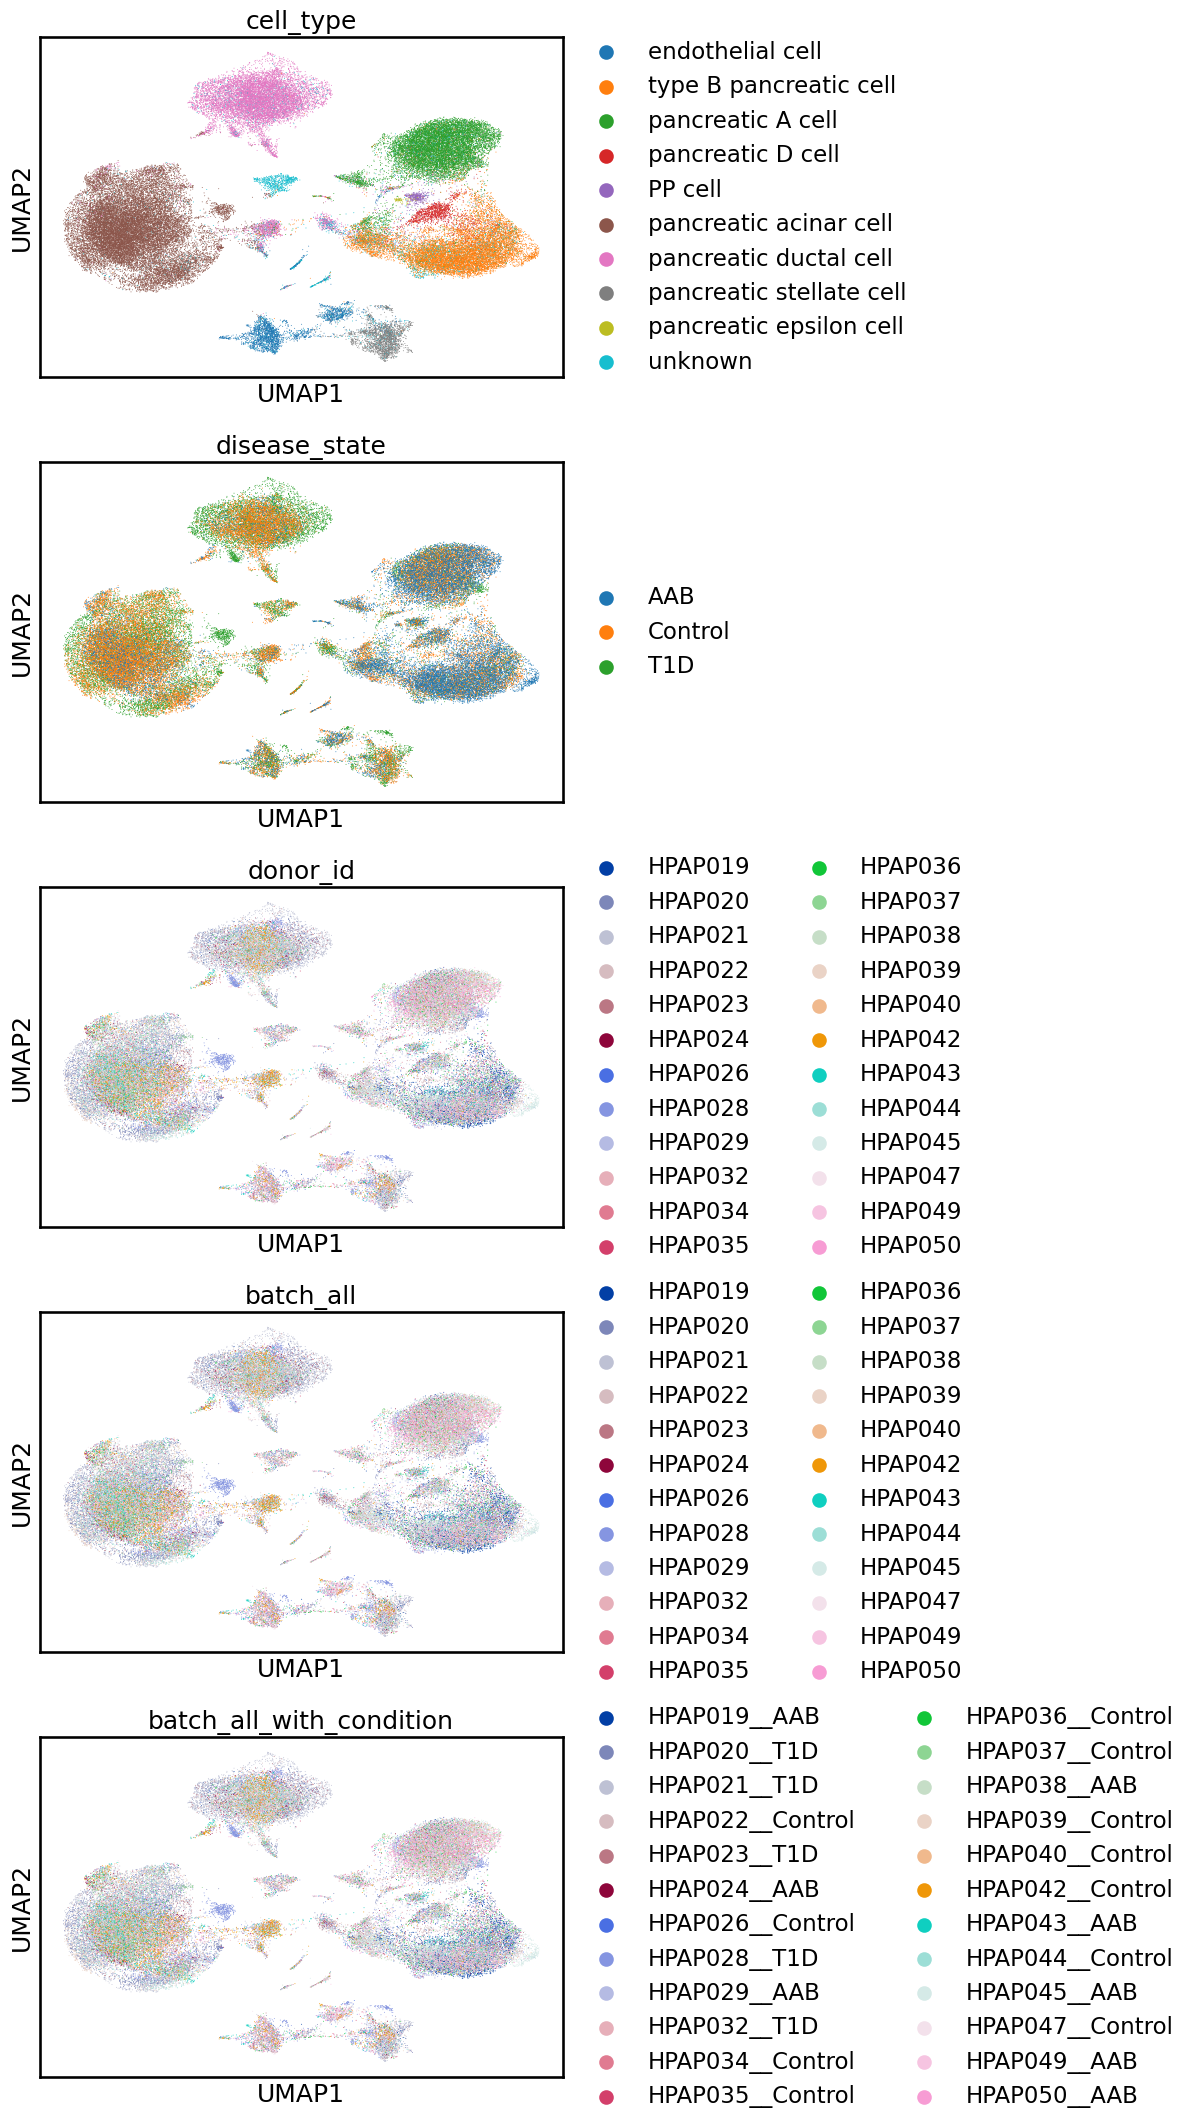

Plot of denoised expression


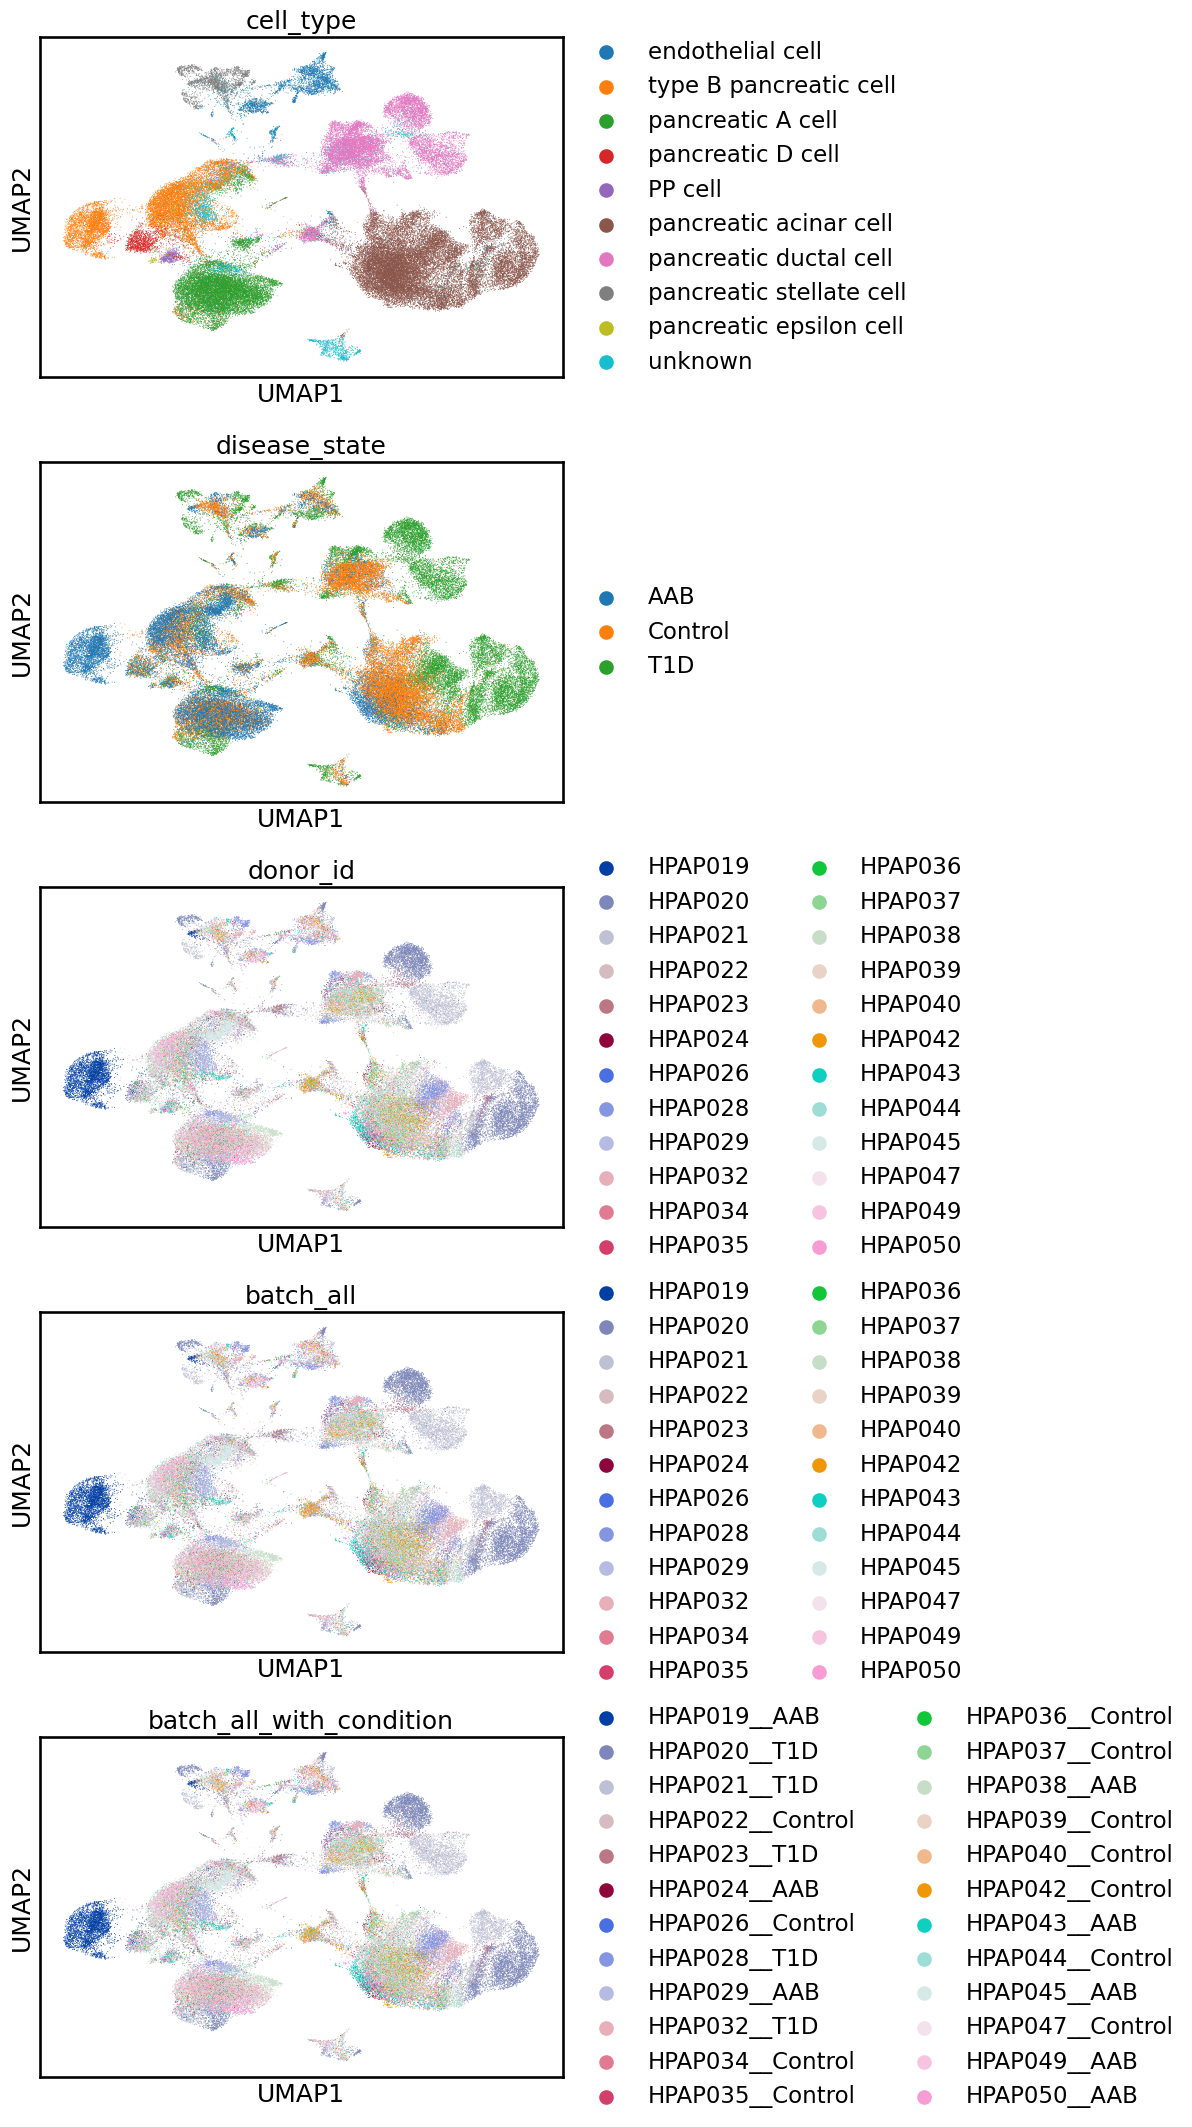

Finish adata preprocessing ====================
Batch-related mixing performance evaluation for main effect:
Batch-related mixing performance evaluation for main effect:
donor_id
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
LISI---


In [ ]:
adata=sc.read_h5ad("./cellanova/t1d_results.h5ad")
evaluate_cellanova(adata=adata,cell_type_key="cell_type",batch_key="donor_id",
                   condition_key="disease_state",dataset_name="t1d")

# Human kidney multiomics atlas

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211785

In [ ]:
adata=sc.read_h5ad("./cellanova/kidney_results.h5ad")
evaluate_cellanova(adata=adata,cell_type_key='Cluster_Idents',batch_key=['sample','tech'],
                   condition_key="Status",dataset_name="kidney")

# Mouse radiation experiment dataset

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE280883

adata preprocessing...
batch_all ['D10__1.0__CY' 'D10__1.0__LL' 'D20__1.0__CY' 'D2__1.0__CY' 'D2__2.0__CY'
 'D3.5__1.0__LL' 'D3.5__2.0__LL' 'D3.5__3.0__LL' 'D3.5__4.0__LL']
batch_all_with_condition ['D10__1.0__CY__C' 'D10__1.0__CY__SR' 'D10__1.0__LL__SR' 'D20__1.0__CY__C'
 'D20__1.0__CY__SR' 'D2__1.0__CY__C' 'D2__1.0__CY__SR' 'D2__2.0__CY__SR'
 'D3.5__1.0__LL__C' 'D3.5__1.0__LL__SR' 'D3.5__2.0__LL__C'
 'D3.5__2.0__LL__SR' 'D3.5__3.0__LL__SR' 'D3.5__4.0__LL__SR']
Plot of main effect:


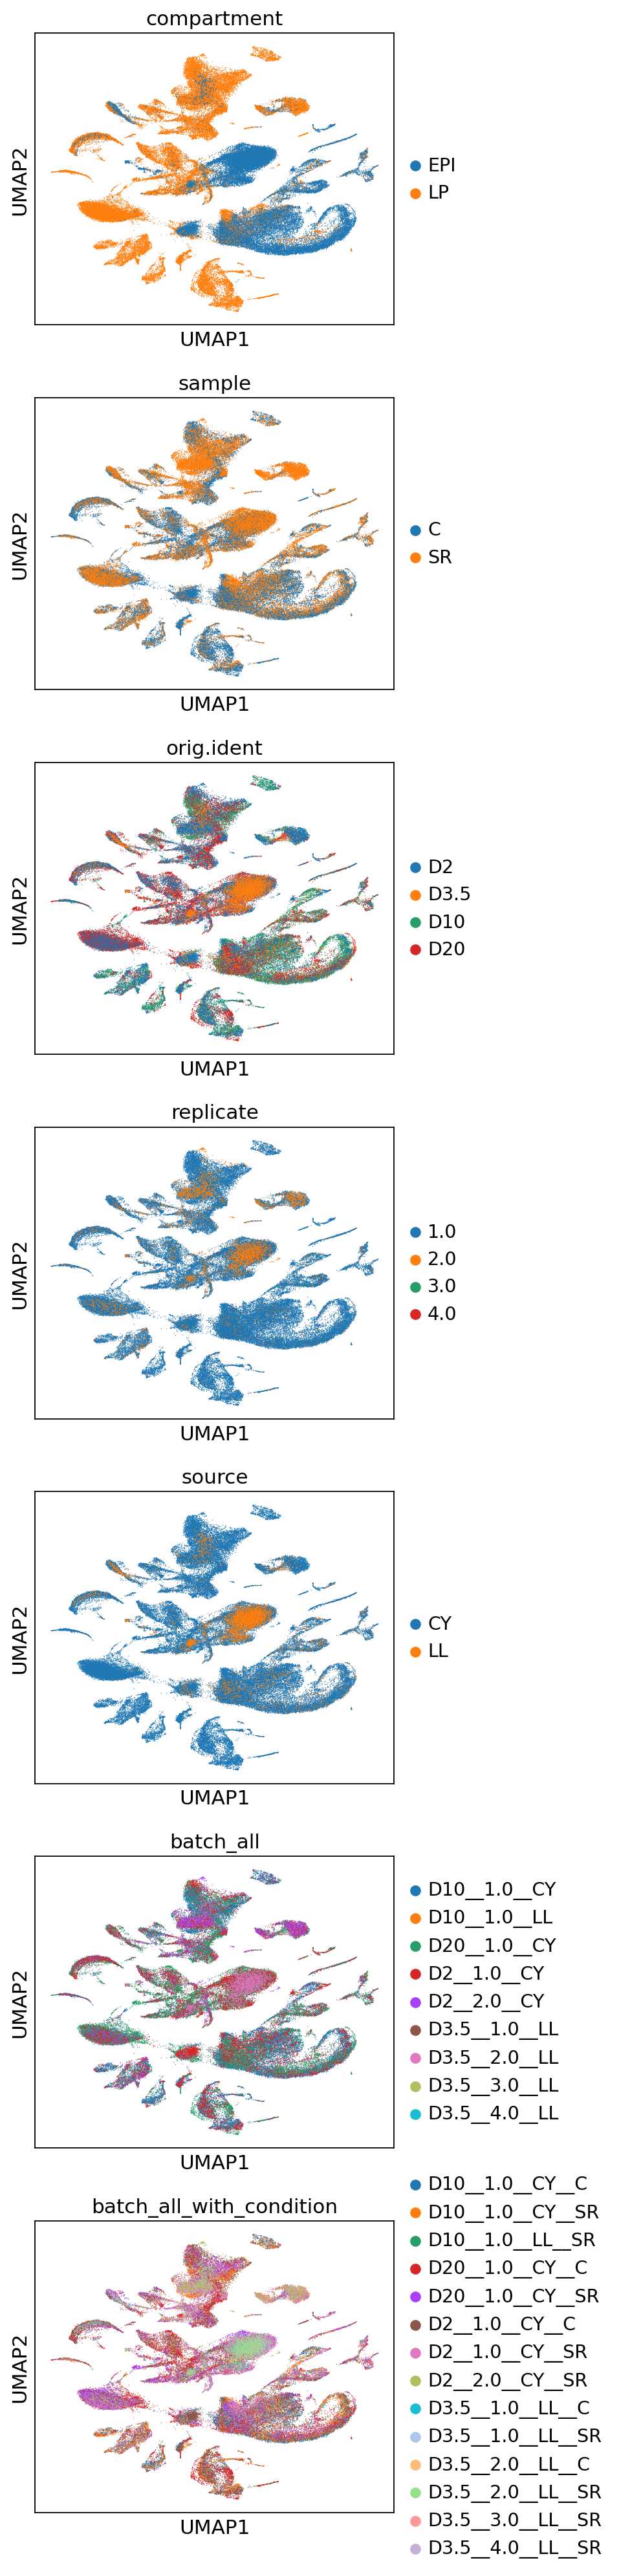

Plot of denoised expression


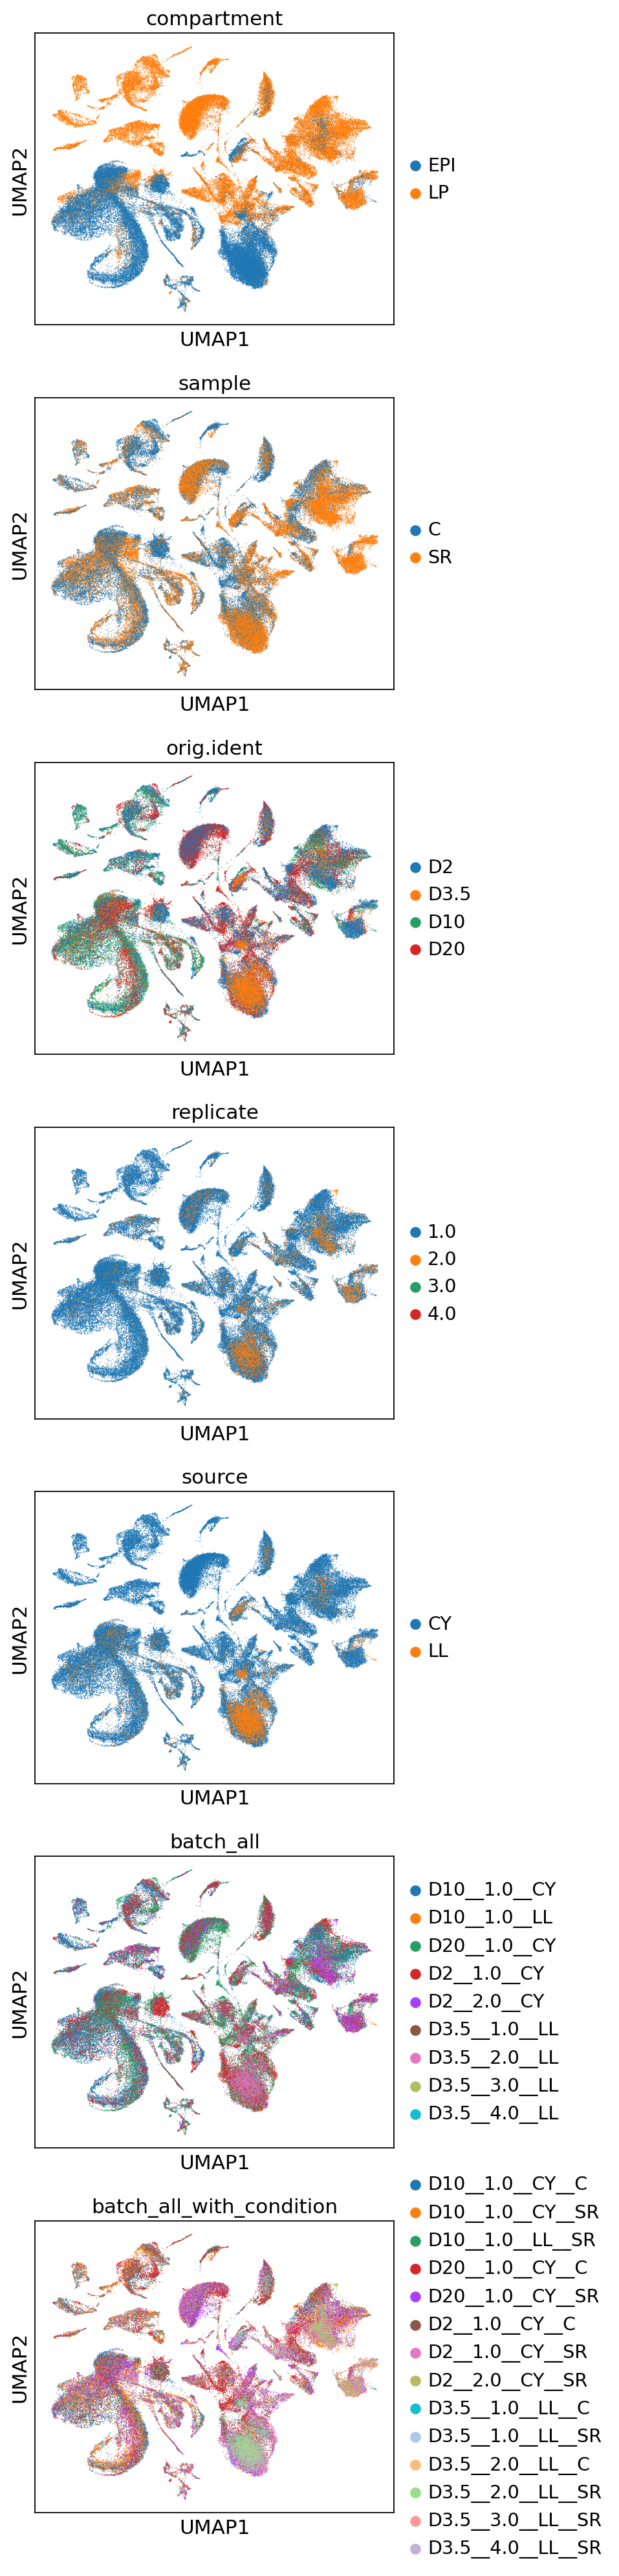

Finish adata preprocessing ====================
Batch-related mixing performance evaluation for main effect:
Batch-related mixing performance evaluation for main effect:
orig.ident
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
LISI---
cLISI, bLISI, LISI_F1 0.8897787732155227 0.3440626722649895 0.49623825420773177
ASW---
asw_label 0.5367187932133675
asw_batch 0.8460693257371856
kBET---


UndefinedVariableError: name 'orig' is not defined

In [3]:
adata=sc.read_h5ad("./cellanova/mouse_results.h5ad")
adata.obs['orig_ident']=adata.obs['orig.ident'].copy()
evaluate_cellanova(adata=adata,cell_type_key='compartment',batch_key=['orig_ident',"replicate","source"],
                   condition_key="sample",dataset_name="mouse")